## Notebook de Consultas

Uso do modelo `anp` em base Apache Cassandra para realização de consultas para respostas a questões do negócio.

A base contém histórico de preços de combustíveis em todo o Brasil.

In [14]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pyspark.sql.functions as F

# Crie uma sessão do Spark
spark = ( 
    SparkSession.builder.appName("Cassandra")
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.4.1")
    .getOrCreate()
)

Obter um dataframe para representar a tabela `precos_combustiveis_por_produto_e_uf` do nosso modelo no Cassandra.

In [3]:
# Propriedades de conexão com o Cassandra
CASSANDRA_CONF = {
    "spark.cassandra.connection.host": "cassandra",
    "spark.cassandra.connection.port": 9042,
}

df_precos = (
    spark.read
    .format("org.apache.spark.sql.cassandra")
    .options(**CASSANDRA_CONF)
    .options(keyspace="anp", table="precos_combustiveis_por_produto_e_uf")
    .load()
)

Obter dataframes para os dados de São Paulo e Rio de Janeiro para o preço da Gasolina dia a dia durante 2022.

In [24]:
df_precos_gasolina_2022 = (
    df_precos
    .filter("produto = 'Gasolina' and sigla_uf in ('SP', 'RJ')")
    .filter("data_coleta >= '2022-01-01' and data_coleta <= '2022-12-31'")
    .groupBy('produto', 'sigla_uf', 'data_coleta')
    .agg(
        F.avg('preco_venda').alias('preco_medio'),
        F.min('preco_venda').alias('preco_minimo'),
        F.max('preco_venda').alias('preco_maximo')
    )
)

df_precos_gasolina_2022.show(20)

+--------+--------+-----------+--------------------+--------------------+--------------------+
| produto|sigla_uf|data_coleta|         preco_medio|        preco_minimo|        preco_maximo|
+--------+--------+-----------+--------------------+--------------------+--------------------+
|Gasolina|      RJ| 2022-03-29|7.776929133858267...|7.290000000000000000|8.380000000000000000|
|Gasolina|      RJ| 2022-11-30|5.126315789473684...|4.630000000000000000|5.590000000000000000|
|Gasolina|      SP| 2022-04-07|6.798250000000000...|6.290000000000000000|7.490000000000000000|
|Gasolina|      SP| 2022-08-09|5.406698072805139...|4.740000000000000000|6.990000000000000000|
|Gasolina|      RJ| 2022-01-13|7.351052631578947...|6.990000000000000000|7.790000000000000000|
|Gasolina|      SP| 2022-08-18|5.235039370078740...|4.630000000000000000|6.990000000000000000|
|Gasolina|      RJ| 2022-05-10|7.957474747474747...|7.590000000000000000|8.490000000000000000|
|Gasolina|      SP| 2022-05-17|6.921912568306010..

Comparando os precos mínimo, médio e máximo para consolidado do ano de 2022.

In [25]:
( 
    df_precos_gasolina_2022
    .groupBy('produto', 'sigla_uf')
    .agg(
        F.avg('preco_medio'),
        F.min('preco_minimo'),
        F.max('preco_maximo')
    )
).show()

+--------+--------+--------------------+--------------------+--------------------+
| produto|sigla_uf|    avg(preco_medio)|   min(preco_minimo)|   max(preco_maximo)|
+--------+--------+--------------------+--------------------+--------------------+
|Gasolina|      RJ|6.641778976439355...|4.390000000000000000|8.990000000000000000|
|Gasolina|      SP|5.917058241735692...|4.090000000000000000|8.890000000000000000|
+--------+--------+--------------------+--------------------+--------------------+



Analisando os preços por consolidado mensal.

In [54]:
df_precos_gasolina_mensal_2022 = (
    df_precos_gasolina_2022
    .withColumn('mes', F.month('data_coleta'))
    .groupBy('produto', 'sigla_uf', 'mes')
    .agg(
        F.avg('preco_medio').alias('preco_medio'),
        F.min('preco_minimo').alias('preco_minimo'),
        F.max('preco_maximo').alias('preco_maximo')
    )
)

df_precos_gasolina_mensal_2022.show(20)

+--------+--------+---+--------------------+--------------------+--------------------+
| produto|sigla_uf|mes|         preco_medio|        preco_minimo|        preco_maximo|
+--------+--------+---+--------------------+--------------------+--------------------+
|Gasolina|      RJ|  7|6.234544748995223...|5.190000000000000000|7.990000000000000000|
|Gasolina|      RJ|  6|7.831334555905333...|6.890000000000000000|8.990000000000000000|
|Gasolina|      RJ|  2|7.311781662634185...|6.490000000000000000|7.990000000000000000|
|Gasolina|      RJ|  4|7.902919244635674...|6.990000000000000000|8.510000000000000000|
|Gasolina|      RJ|  3|7.613585270849374...|6.390000000000000000|8.390000000000000000|
|Gasolina|      SP|  3|6.658487394290051...|5.570000000000000000|8.490000000000000000|
|Gasolina|      SP|  5|6.941960338469784...|6.180000000000000000|8.590000000000000000|
|Gasolina|      RJ| 12|5.060729619036819...|4.620000000000000000|5.890000000000000000|
|Gasolina|      SP|  1|6.371510564259590...

Convertendo para um dataframe Pandas para geração de gráficos. Salvando a amostra de dados como planilha CSV.

In [57]:
precos_diarios = df_precos_gasolina_2022.toPandas()
precos_diarios.to_csv('precos_diarios_gasolina_2022.csv', index=False)

precos_mensais = df_precos_gasolina_mensal_2022.toPandas()
precos_mensais.to_csv('precos_mensais_gasolina_2022.csv', index=False)

Gráfico de dispersão para comparação dos preços de RJ e SP

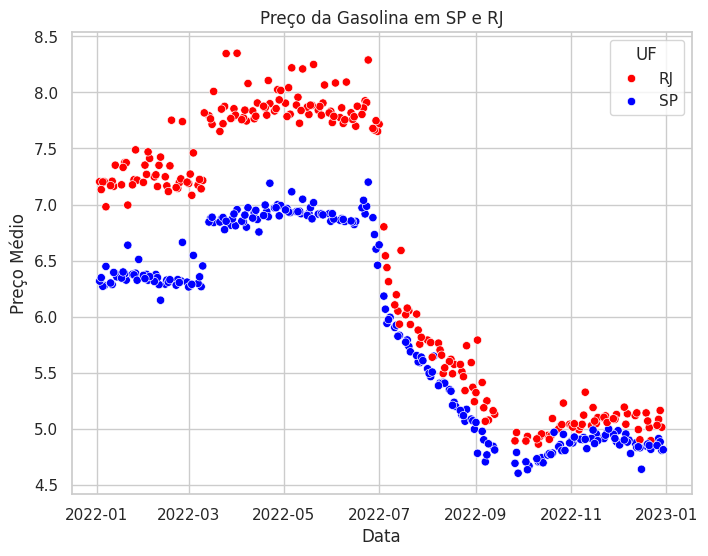

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações do gráfico de dispersão
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))

# Gráfico de dispersão combinando SP e RJ
sns.scatterplot(x='data_coleta', y='preco_medio', data=precos_diarios, hue='sigla_uf', palette={'SP': 'blue', 'RJ': 'red'})
plt.xlabel('Data')
plt.ylabel('Preço Médio')
plt.title('Preço da Gasolina em SP e RJ')

plt.legend(title='UF', loc='upper right')

# Mostrando o gráfico
plt.show()

O gráfico permite concluir que o preço médio da Gasolina no RJ esteve superior ao de SP durante todo o ano. Podemos ver também que a diferença era bastante superior no primeiro semestre.

Em meados do ano foi sancionada lei para limitar a cobrança do imposto estadual (ICMS) nos combustíveis, o que explica a queda na diferença de preço.

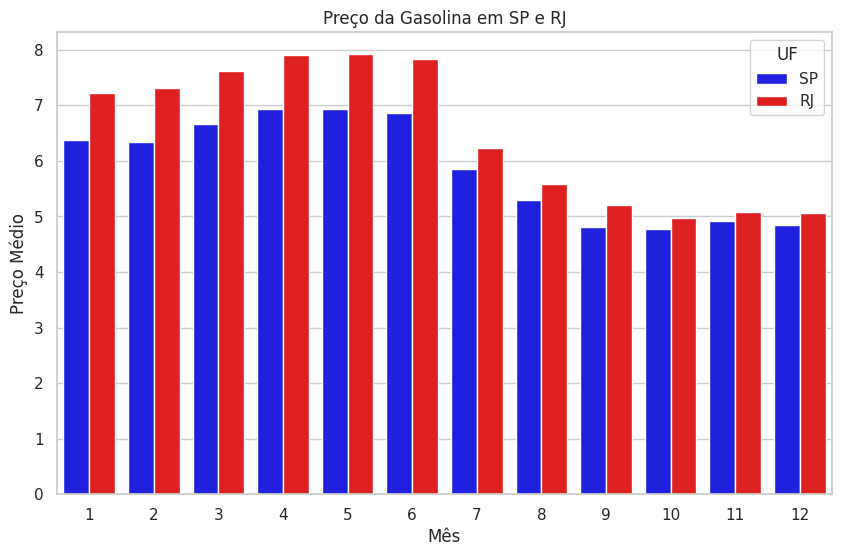

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.barplot(x='mes', y='preco_medio', hue='sigla_uf', palette={'SP': 'blue', 'RJ': 'red'}, data=precos_mensais)
plt.xlabel('Mês')
plt.ylabel('Preço Médio')
plt.title('Preço da Gasolina em SP e RJ')
plt.legend(title='UF')
plt.show()

O gráfico mensal permite visualizar melhor as diferenças de preço entre os semestres.